# IBM Q Opgave 4: Grovers Algoritme
### Skrevet af Anna Liv Paludan Bjerregaard

I denne opgave skal vi kigge på en rigtig kvante-algoritme, altså en algoritme som kan køre på en kvantecomputer. Mere specifikt kigger vi på Grovers algoritme, som er beskrevet i sektion 12 af noterne.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble

from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

Vi starter med at lave et kredsløb som anvender Grovers algoritme på 2 qubits - dvs at vi søger i et rum med $2^2=4$ muligheder: 00, 01, 10 og 11. Lad os sige at vi gerne vil have at kredsløbet finder frem til resulatet 11. Det indkoder vi i "Oraklet", hvilket kan føles som snyd, men tænk på det som en søgealgoritme. Hvis du søger efter noget på Google så skriver du jo også hvad du søger efter!

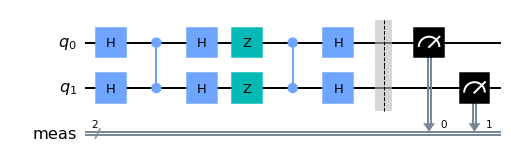

In [3]:
n = 2
grover_circuit = QuantumCircuit(n)
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc
grover_circuit = initialize_s(grover_circuit, [0,1])
#grover_circuit.x(0)#apply to modify oracle
#grover_circuit.x(1)#apply to modify oracle
grover_circuit.cz(0,1) # Oracle
#grover_circuit.x(0)#apply to modify oracle
#grover_circuit.x(1)#apply to modify oracle
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.measure_all()
grover_circuit.draw()

Du behøver ikke at forstå diagrammet, men hvis du har lyst kan du prøve at læse det igennem og se om du kan tyde det.

Hvis algoritmen virker som den skal, så burde den komme frem til resultatet 11 *hver gang* vi måler. Prøv at køre nedestående først som simulation (`sim = True`) og dernæst på en ægte kvantecomputer (`sim = False`). Forventer du forskellige resultater med de to metoder?

In [14]:
sim = True
N_measure = 1024

{'|00>': 0, '|10>': 0, '|01>': 0, '|11>': 1024}


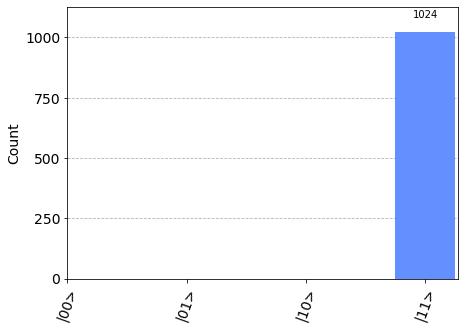

In [15]:
if sim:
    simulator = Aer.get_backend('aer_simulator')
    Nmeasure = N_measure #Amount of times the circuit is run
    result = simulator.run(grover_circuit, shots=Nmeasure).result() 
    device_counts = result.get_counts() #Saves results as dictionary object
    #Simulation code
else:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
    n=3
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                       not x.configuration().simulator and x.status().operational==True))
    #Finds the least busy quantum computer on the IBM Q network
    print("least busy backend: ", backend)

# Execute and monitor the job
    from qiskit.tools.monitor import job_monitor
    shots = 1024
    transpiled_circ = transpile(grover_circuit, backend, optimization_level=3) 
    qobj = assemble(transpiled_circ, shots=shots)
    job = backend.run(qobj) #Send circuit to the quantum computer
    job_monitor(job, interval=2)
    device_counts = job.result().get_counts()

possible_measurements = ['00','10','01','11']
measurement_names = ['|00>','|10>','|01>','|11>']

for name, measurement in zip(measurement_names, possible_measurements):
    try:
        device_counts[name] = device_counts.pop(measurement)
    except:
        device_counts[name] = 0

print(device_counts)
plot_histogram(device_counts)

Hvis du nåede at prøve med en ægte kvantecomputer: Hvordan ændrede resultatet sig ift simulationen? Hvorfor?

Nu har du prøvet at køre en ægte kvantealgoritme!
Gennem disse øvelser har du lært om

1. Hvad en qubit er

2. Hvordan man måler på dem

3. Sammenfiltring af qubits

4. Hvordan man bruger qubits til at lave algoritmer på kvantecomputere

og du er klædt godt på til at gå længere ind i kvantecomputernes verden!

**Ekstraopgave:** Lad os prøve at køre Grovers algoritme med tre qubits! Dette giver os $2^3 = 8$ muligheder og vi vælger $|111\rangle$ som løsning. Du kan tweake `n_grover` variablen for at styre hvor mange gange Grovers algoritme anvendes! Prøv med nogle forskellige værdier og se hvordan resultatet ændrer sig. Hvis ventetiden ikke er for lang, så prøv også at køre jobbet på en ægte kvantecomputer ved at sætte `sim = False`.

In [34]:
qc = QuantumCircuit(3)
#qc.cz(0, 2)#This and the next line picks |101> and |110>
#qc.cz(1, 2)
qc.h(2)#the ande the following 2 lines picks the |111> state 
qc.ccx(0,1,2)
qc.h(2)

oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

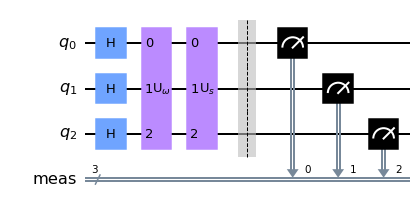

In [51]:
n = 3
n_grover = 1

grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
for i in range(n_grover):
    grover_circuit.append(oracle_ex3, [0,1,2])
    grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

In [52]:
sim = True
N_measure = 1024

{'|000>': 30, '|001>': 34, '|010>': 39, '|011>': 32, '|100>': 25, '|101>': 32, '|110>': 27, '|111>': 805}


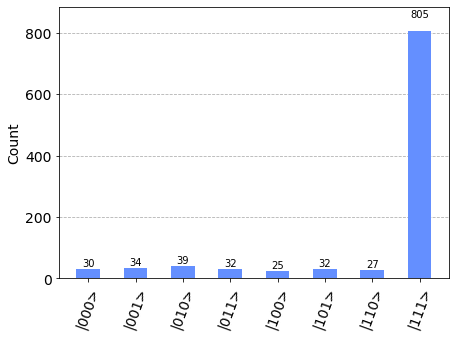

In [53]:
if sim:
    aer_sim = Aer.get_backend('aer_simulator')
    transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
    qobj = assemble(transpiled_grover_circuit)
    results = aer_sim.run(qobj).result()
    device_counts = results.get_counts()
    #Simulation code
else:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
    n=3
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                       not x.configuration().simulator and x.status().operational==True))
    #Finds the least busy quantum computer on the IBM Q network
    print("least busy backend: ", backend)

# Execute and monitor the job
    from qiskit.tools.monitor import job_monitor
    shots = 1024
    transpiled_circ = transpile(grover_circuit, backend, optimization_level=3) 
    qobj = assemble(transpiled_circ, shots=shots)
    job = backend.run(qobj) #Send circuit to the quantum computer
    job_monitor(job, interval=2)
    device_counts = job.result().get_counts()

possible_measurements = ['000','001','010','011','100','101','110','111']
measurement_names = ['|000>','|001>','|010>','|011>','|100>','|101>','|110>','|111>']

for name, measurement in zip(measurement_names, possible_measurements):
    try:
        device_counts[name] = device_counts.pop(measurement)
    except:
        device_counts[name] = 0

print(device_counts)
plot_histogram(device_counts)